
# AI vs Real Image Detection
This notebook detects whether an image is Real or AI‑Generated using a hybrid approach:
- Frequency analysis (FFT)
- Face region analysis (MTCNN)
- Semantic understanding (CLIP model)
- Ensemble decision logic


# AI vs Real Image Detection (Hybrid FFT + CLIP)
End-to-end demo: load models → upload image → predict → visualize

## Environment Setup
Install required libraries and compatible versions.

In [ ]:
# clean conflicting packages
!pip uninstall -y torch torchvision torchaudio transformers facenet-pytorch -q

# install compatible versions
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 -q
!pip install transformers==4.41.2 facenet-pytorch==2.5.3 pillow matplotlib numpy -q

print("Environment Ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.2 requires transformers<6.0.0,>=4.41.0, which is not installed.
peft 0.18.1 requires transformers, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.9 MB/s eta 0:00:00
Environment Ready


In [ ]:

!pip -q install facenet-pytorch transformers pillow matplotlib numpy torch torchvision


## Model Loading
Loads face detection (MTCNN) and semantic vision model (CLIP).

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from facenet_pytorch import MTCNN
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Using Device:", device)

mtcnn = MTCNN(keep_all=True, device=device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


Using Device: cpu


## Frequency Analysis
Analyzes high‑frequency texture patterns typical in AI‑generated images.

In [ ]:
def fft_frequency_score(image_pil):
    gray = image_pil.convert("L")
    img = np.array(gray, dtype=np.float32)

    fft = np.fft.fft2(img)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.log(np.abs(fft_shift) + 1.0)

    h, w = magnitude.shape
    magnitude[h//2-10:h//2+10, w//2-10:w//2+10] = 0

    energy = np.mean(magnitude)
    max_energy = np.max(magnitude) + 1e-8

    return float(np.clip(energy / max_energy, 0.0, 1.0))


## Frequency Analysis
Analyzes high‑frequency texture patterns typical in AI‑generated images.

## Face Region Detection
Analyzes only facial areas because synthetic faces contain detectable artifacts.

In [ ]:
def face_only_fft_score(image_pil):
    boxes, _ = mtcnn.detect(image_pil)

    if boxes is None or len(boxes) == 0:
        return fft_frequency_score(image_pil)

    scores = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        face = image_pil.crop((max(0,x1),max(0,y1),min(image_pil.width,x2),min(image_pil.height,y2)))

        if face.width > 40 and face.height > 40:
            scores.append(fft_frequency_score(face))

    return float(np.mean(scores)) if scores else fft_frequency_score(image_pil)


## Semantic Classification
CLIP compares image meaning with prompts describing real vs AI images.

In [ ]:
def clip_ai_score(image_pil):
    prompts = [
        "a real photograph taken with a camera",
        "a natural unedited photo",
        "an AI-generated image",
        "a synthetic digital artwork"
    ]

    inputs = clip_processor(text=prompts, images=image_pil, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        logits = clip_model(**inputs).logits_per_image[0]
        probs = logits.softmax(dim=0)

    real_prob = float(probs[0] + probs[1])
    ai_prob = float(probs[2] + probs[3])

    return ai_prob / (ai_prob + real_prob + 1e-8)


## Ensemble Decision
Combines FFT + CLIP scores to produce final classification.

In [ ]:
def image_decision(fft_score, clip_score):
    combined = 0.65 * fft_score + 0.35 * clip_score

    if fft_score > 0.72 and clip_score > 0.75:
        return "AI-Generated", int(combined * 100)

    if fft_score < 0.40 and clip_score < 0.45:
        return "Real", int((1 - combined) * 100)

    return "Possibly AI-Generated", int(abs(combined - 0.5) * 200)


## Face Region Detection
Analyzes only facial areas because synthetic faces contain detectable artifacts.

## Semantic Classification
CLIP compares image meaning with prompts describing real vs AI images.

## Ensemble Decision
Combines FFT + CLIP scores to produce final classification.

## Upload Test Image
Upload an image to test the model.

Saving real2.jpeg to real2.jpeg


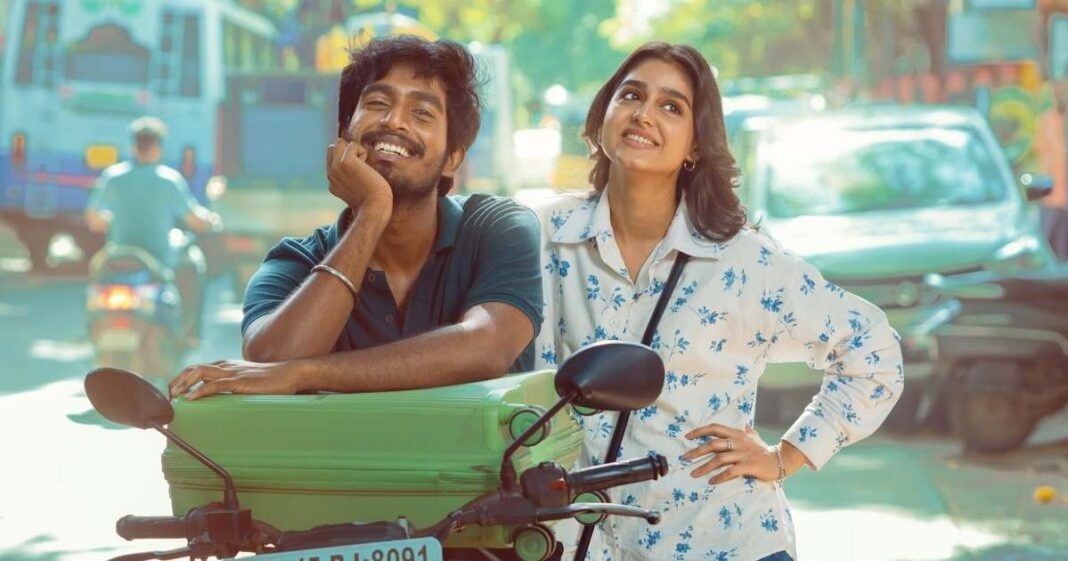

FFT: 0.59
CLIP: 0.208
Prediction: Possibly AI-Generated
Confidence: 8 %


In [ ]:
from google.colab import files
uploaded = files.upload()

path = list(uploaded.keys())[0]
image = Image.open(path).convert("RGB")
display(image)

fft_score = face_only_fft_score(image)
clip_score = clip_ai_score(image)
label, confidence = image_decision(fft_score, clip_score)

print("FFT:", round(fft_score,3))
print("CLIP:", round(clip_score,3))
print("Prediction:", label)
print("Confidence:", confidence,"%")


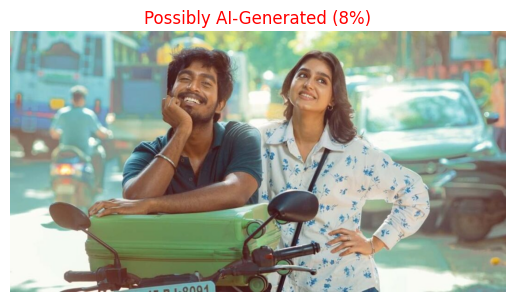

In [ ]:
plt.imshow(image)
plt.axis("off")
plt.title(f"{label} ({confidence}%)", color="red")
plt.show()


## Upload Test Image
Upload an image to test the model.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test_images.zip to test_images.zip


In [ ]:
import zipfile

with zipfile.ZipFile("test_images.zip", 'r') as zip_ref:
    zip_ref.extractall()

print("Extracted!")


Extracted!


## Face Region Detection
Analyzes only facial areas because synthetic faces contain detectable artifacts.

## Semantic Classification
CLIP compares image meaning with prompts describing real vs AI images.

## Ensemble Decision
Combines FFT + CLIP scores to produce final classification.

In [ ]:
import os

results = []
folder = "test_images"

for file in os.listdir(folder):

    if not file.lower().endswith(('.png','.jpg','.jpeg','.webp')):
        continue

    path = os.path.join(folder, file)
    img = Image.open(path).convert("RGB")

    fft_score = face_only_fft_score(img)
    clip_score = clip_ai_score(img)
    label, confidence = image_decision(fft_score, clip_score)

    actual = "Real" if "real" in file.lower() else "AI-Generated"

    results.append([file, actual, label, confidence, fft_score, clip_score])

df = pd.DataFrame(results, columns=["Image","Actual","Predicted","Confidence","FFT","CLIP"])
df


,Image,Actual,Predicted,Confidence,FFT,CLIP
0,real1.jpg,Real,Possibly AI-Generated,11,0.626988,0.096507
1,ai2.png,AI-Generated,Possibly AI-Generated,33,0.604316,0.787037
2,ai1.png,AI-Generated,Possibly AI-Generated,17,0.631138,0.505307
3,real2.jpeg,Real,Possibly AI-Generated,8,0.590204,0.207641


In [ ]:
def is_correct(row):
    if row["Actual"] == "Real" and row["Predicted"] == "Real":
        return True
    if row["Actual"] == "AI-Generated" and row["Predicted"] in ["AI-Generated", "Possibly AI-Generated"]:
        return True
    return False

accuracy = df.apply(is_correct, axis=1).mean()*100
print("Adjusted Accuracy:", round(accuracy,2), "%")


Adjusted Accuracy: 50.0 %


**1. Graph — Prediction Distribution**

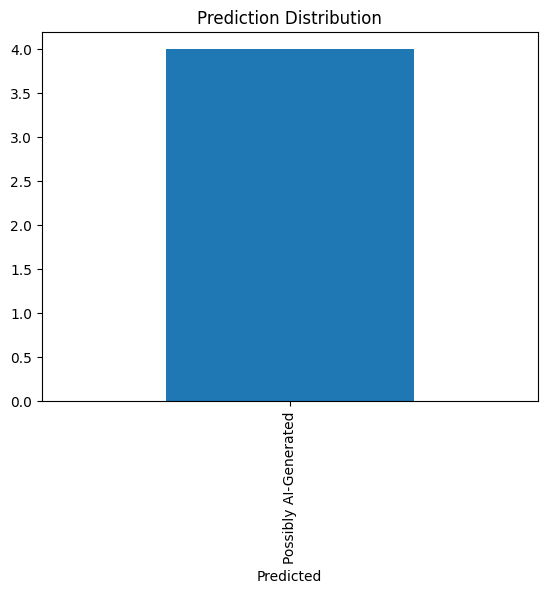

In [ ]:
df["Predicted"].value_counts().plot(kind="bar")
plt.title("Prediction Distribution")
plt.show()


**2. Graph — Confidence Histogram**

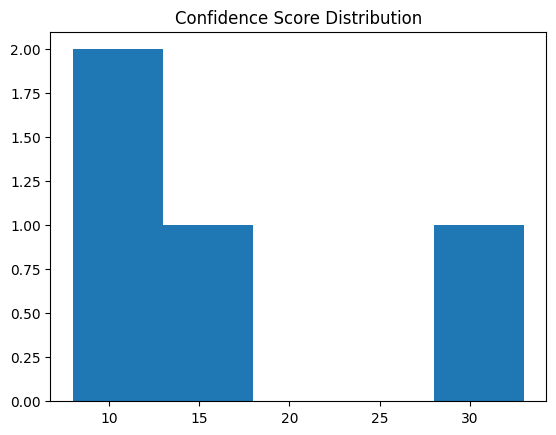

In [ ]:
plt.hist(df["Confidence"], bins=5)
plt.title("Confidence Score Distribution")
plt.show()


**3. Graph — Real vs AI Pie**

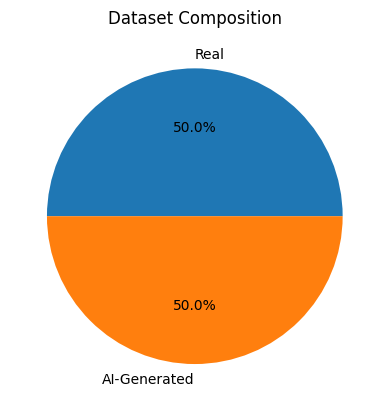

In [ ]:
df["Actual"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Dataset Composition")
plt.ylabel("")
plt.show()


**4. Graph — Detector Agreement**

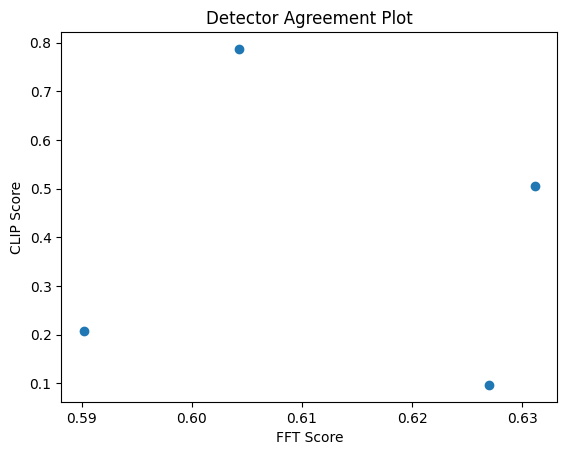

In [ ]:
plt.scatter(df["FFT"], df["CLIP"])
plt.xlabel("FFT Score")
plt.ylabel("CLIP Score")
plt.title("Detector Agreement Plot")
plt.show()
